## 1. Setup and Imports

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

# Set plotting style
sns.set_theme()
plt.rcParams['font.size'] = 12
%matplotlib inline

# Paths
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
TRAIN_TERMS = ROOT / "cafa6_data" / "Train" / "train_terms.tsv"
IA_TSV = ROOT / "cafa6_data" / "IA.tsv"
LEVEL1_PREDS = ROOT / "cafa6_data" / "features" / "level1_preds"

print(f"Root: {ROOT}")
print(f"Train Terms: {TRAIN_TERMS}")
print(f"IA TSV: {IA_TSV}")
print(f"Level 1 Predictions: {LEVEL1_PREDS}")

Root: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction
Train Terms: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\cafa6_data\Train\train_terms.tsv
IA TSV: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\cafa6_data\IA.tsv
Level 1 Predictions: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\cafa6_data\features\level1_preds


## 2. Load Ground Truth

In [2]:
print("Loading ground truth from train_terms.tsv...")
train_df = pd.read_csv(TRAIN_TERMS, sep='\t')
print(f"Loaded {len(train_df):,} annotations for {train_df['EntryID'].nunique():,} proteins")

# Display sample
train_df.head()

Loading ground truth from train_terms.tsv...
Loaded 537,027 annotations for 82,404 proteins


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


In [3]:
# Map single-letter aspect codes to full names
aspect_map = {'P': 'BP', 'F': 'MF', 'C': 'CC'}
aspects = ['BP', 'MF', 'CC']

# Lightweight sanity checks on the ground truth table
missing_aspect = train_df['aspect'].isna().sum()
missing_term = train_df['term'].isna().sum()
missing_entry = train_df['EntryID'].isna().sum()
print(f"Missing: EntryID={missing_entry:,}, term={missing_term:,}, aspect={missing_aspect:,}")

print("Annotations per aspect:")
train_df['aspect_full'] = train_df['aspect'].map(aspect_map)
display(train_df['aspect_full'].value_counts(dropna=False).rename('n_annotations').to_frame())

Missing: EntryID=0, term=0, aspect=0
Annotations per aspect:


,n_annotations
aspect_full,
BP,250805
CC,157770
MF,128452


## 3. Load Model Artefacts

In [4]:
# Load top terms
print("Loading top terms...")
top_terms = {}
for aspect in aspects:
    with open(LEVEL1_PREDS / f"top_terms_{aspect}.json", 'r') as f:
        top_terms[aspect] = json.load(f)
    print(f"  {aspect}: {len(top_terms[aspect]):,} terms")

Loading top terms...
  BP: 10,000 terms
  MF: 2,000 terms
  CC: 1,500 terms


In [5]:
# Load OOF predictions
print("Loading OOF predictions...")
oof_preds = {}
for aspect in aspects:
    oof_preds[aspect] = np.load(LEVEL1_PREDS / f"oof_pred_logreg_{aspect}.npy")
    print(f"  LogReg {aspect}: {oof_preds[aspect].shape}")

# Load GBDT OOF predictions
oof_gbdt = np.load(LEVEL1_PREDS / "oof_pred_gbdt.npy")
print(f"  GBDT: {oof_gbdt.shape}")

Loading OOF predictions...
  LogReg BP: (82404, 10000)
  LogReg MF: (82404, 2000)
  LogReg CC: (82404, 1500)
  GBDT: (82404, 13500)


In [6]:
# Reconstruct protein IDs in the exact row order used by the OOF arrays
train_seq = pd.read_feather(ROOT / "cafa6_data" / "parsed" / "train_seq.feather")
train_protein_ids_all = train_seq['id'].str.extract(r"\|(.*?)\|")[0].fillna(train_seq['id']).tolist()

# Determine n_samples from the OOF arrays (they must match)
n_samples = int(oof_gbdt.shape[0])
train_protein_ids = train_protein_ids_all[:n_samples]
print(f"Protein IDs: {len(train_protein_ids):,} (from train_seq.feather)")
print(f"OOF rows:    {n_samples:,}")

# Defensive check: duplicates will break mapping EntryID -> row index
n_unique = len(set(train_protein_ids))
if n_unique != len(train_protein_ids):
    raise ValueError(f"Duplicate EntryIDs in the first {n_samples} proteins: {len(train_protein_ids)-n_unique}")

Protein IDs: 82,404 (from train_seq.feather)
OOF rows:    82,404


## 4. Define Evaluation Functions

In [7]:
# --- IA-weighted evaluation (CAFA metric) ---

def load_term_contract(level1_preds: Path):
    top_bp = json.load(open(level1_preds / 'top_terms_BP.json', 'r'))
    top_mf = json.load(open(level1_preds / 'top_terms_MF.json', 'r'))
    top_cc = json.load(open(level1_preds / 'top_terms_CC.json', 'r'))
    top_terms_all = top_bp + top_mf + top_cc
    slices = {
        'BP': slice(0, len(top_bp)),
        'MF': slice(len(top_bp), len(top_bp) + len(top_mf)),
        'CC': slice(len(top_bp) + len(top_mf), len(top_terms_all)),
    }
    return top_terms_all, slices, {'BP': top_bp, 'MF': top_mf, 'CC': top_cc}


def load_ia_weights(ia_tsv: Path, top_terms_all: list[str]) -> np.ndarray:
    ia_df = pd.read_csv(ia_tsv, sep='\t', header=None, names=['term', 'ia'])
    ia_series = ia_df.set_index('term')['ia']
    reindexed = ia_series.reindex(top_terms_all)
    ia_weights = reindexed.fillna(0.0).astype(np.float32).to_numpy()
    n_missing = int(reindexed.isna().sum())
    if n_missing > 0:
        print(f"Warning: {n_missing:,} contract terms missing IA; using 0.0 for those")
    return ia_weights


def build_y_true_sparse(train_df: pd.DataFrame, protein_ids: list[str], top_terms_all: list[str]) -> sp.csr_matrix:
    n_samples = len(protein_ids)
    n_terms = len(top_terms_all)
    row_index = pd.Series(np.arange(n_samples, dtype=np.int32), index=protein_ids)
    col_index = pd.Series(np.arange(n_terms, dtype=np.int32), index=top_terms_all)

    df = train_df[['EntryID', 'term']].copy()
    df['row'] = df['EntryID'].map(row_index)
    df['col'] = df['term'].map(col_index)
    df = df.dropna(subset=['row', 'col'])
    rows = df['row'].astype(np.int32).to_numpy()
    cols = df['col'].astype(np.int32).to_numpy()
    data = np.ones(len(df), dtype=np.int8)

    y_true = sp.coo_matrix((data, (rows, cols)), shape=(n_samples, n_terms), dtype=np.int8).tocsr()
    y_true.sum_duplicates()
    y_true.data[:] = 1
    print(f"Y_true: shape={y_true.shape}, nnz={y_true.nnz:,} (only terms in 13,500 contract)")
    return y_true


def ia_f1_streaming(y_prob_getter, y_true_csr: sp.csr_matrix, ia_weights: np.ndarray, thr_vec: np.ndarray, batch_size: int = 1024):
    """Streaming IA-weighted micro-F1 across all terms in the contract."""
    n_samples, n_terms = y_true_csr.shape
    if ia_weights.shape[0] != n_terms or thr_vec.shape[0] != n_terms:
        raise ValueError("ia_weights/thr_vec must match number of terms")

    true_counts = np.asarray(y_true_csr.sum(axis=0)).ravel().astype(np.int64)
    weighted_true = float(np.dot(ia_weights, true_counts))

    pred_counts = np.zeros(n_terms, dtype=np.int64)
    tp_counts = np.zeros(n_terms, dtype=np.int64)

    for start in range(0, n_samples, batch_size):
        end = min(n_samples, start + batch_size)
        y_prob = y_prob_getter(start, end)
        if y_prob.shape != (end - start, n_terms):
            raise ValueError(f"y_prob_getter returned {y_prob.shape}, expected {(end-start, n_terms)}")

        y_pred = (y_prob >= thr_vec)  # bool
        pred_counts += y_pred.sum(axis=0).astype(np.int64)

        y_true_batch = y_true_csr[start:end]
        tp_batch = y_true_batch.multiply(y_pred)
        tp_counts += np.asarray(tp_batch.sum(axis=0)).ravel().astype(np.int64)

    weighted_tp = float(np.dot(ia_weights, tp_counts))
    weighted_pred = float(np.dot(ia_weights, pred_counts))

    precision = (weighted_tp / weighted_pred) if weighted_pred > 0 else 0.0
    recall = (weighted_tp / weighted_true) if weighted_true > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    debug = {
        'weighted_tp': weighted_tp,
        'weighted_pred': weighted_pred,
        'weighted_true': weighted_true,
        'pred_nonzero_terms': int(np.sum(pred_counts > 0)),
        'true_nonzero_terms': int(np.sum(true_counts > 0)),
    }
    return f1, precision, recall, debug


def ia_f1_for_slice(y_prob_getter, y_true_csr: sp.csr_matrix, ia_weights: np.ndarray, thr_vec: np.ndarray, col_slice: slice, batch_size: int = 1024):
    """IA-F1 restricted to a slice of term columns (e.g., BP/MF/CC)."""
    y_true_sub = y_true_csr[:, col_slice]
    ia_sub = ia_weights[col_slice]
    thr_sub = thr_vec[col_slice]

    def getter_sub(start, end):
        return y_prob_getter(start, end)[:, col_slice]

    return ia_f1_streaming(getter_sub, y_true_sub, ia_sub, thr_sub, batch_size=batch_size)


# 1) Term contract + IA weights
top_terms_all, contract_slices, top_terms_by_aspect = load_term_contract(LEVEL1_PREDS)
ia_weights = load_ia_weights(IA_TSV, top_terms_all)
print(f"Contract terms: {len(top_terms_all):,} (BP={len(top_terms_by_aspect['BP']):,}, MF={len(top_terms_by_aspect['MF']):,}, CC={len(top_terms_by_aspect['CC']):,})")

# 2) Threshold vector (Rank-1 heuristics)
thr_vec = np.concatenate([
    np.full(len(top_terms_by_aspect['BP']), 0.25, dtype=np.float32),
    np.full(len(top_terms_by_aspect['MF']), 0.35, dtype=np.float32),
    np.full(len(top_terms_by_aspect['CC']), 0.35, dtype=np.float32),
])
assert thr_vec.shape[0] == len(top_terms_all)

# 3) Sparse ground truth matrix aligned to OOF row order and contract term order
Y_true = build_y_true_sparse(train_df, train_protein_ids, top_terms_all)

# 4) Predictions getters (memory safe)
oof_gbdt_mm = np.load(LEVEL1_PREDS / 'oof_pred_gbdt.npy', mmap_mode='r')
lr_bp_mm = np.load(LEVEL1_PREDS / 'oof_pred_logreg_BP.npy', mmap_mode='r')
lr_mf_mm = np.load(LEVEL1_PREDS / 'oof_pred_logreg_MF.npy', mmap_mode='r')
lr_cc_mm = np.load(LEVEL1_PREDS / 'oof_pred_logreg_CC.npy', mmap_mode='r')

def get_gbdt(start, end):
    return np.asarray(oof_gbdt_mm[start:end], dtype=np.float32)

def get_logreg(start, end):
    return np.concatenate([
        np.asarray(lr_bp_mm[start:end], dtype=np.float32),
        np.asarray(lr_mf_mm[start:end], dtype=np.float32),
        np.asarray(lr_cc_mm[start:end], dtype=np.float32),
    ], axis=1)

# 5) Run IA-F1 evaluation
print("\nEvaluating IA-weighted F1 (Rank-1 thresholds)...")
gbdt_f1, gbdt_p, gbdt_r, gbdt_dbg = ia_f1_streaming(get_gbdt, Y_true, ia_weights, thr_vec, batch_size=1024)
lr_f1, lr_p, lr_r, lr_dbg = ia_f1_streaming(get_logreg, Y_true, ia_weights, thr_vec, batch_size=1024)

print(f"GBDT IA-F1:   {gbdt_f1:.4f} (P={gbdt_p:.4f}, R={gbdt_r:.4f})")
print(f"LogReg IA-F1: {lr_f1:.4f} (P={lr_p:.4f}, R={lr_r:.4f})")
print("\nDebug (GBDT):", gbdt_dbg)
print("Debug (LogReg):", lr_dbg)

Contract terms: 13,500 (BP=10,000, MF=2,000, CC=1,500)
Y_true: shape=(82404, 13500), nnz=510,315 (only terms in 13,500 contract)

Evaluating IA-weighted F1 (Rank-1 thresholds)...
GBDT IA-F1:   0.0002 (P=0.0041, R=0.0001)
LogReg IA-F1: 0.0003 (P=0.0002, R=0.0988)

Debug (GBDT): {'weighted_tp': 58.07505878631491, 'weighted_pred': 14339.081854282995, 'weighted_true': 663910.3433291572, 'pred_nonzero_terms': 437, 'true_nonzero_terms': 13500}
Debug (LogReg): {'weighted_tp': 65565.63464515016, 'weighted_pred': 402145507.84074295, 'weighted_true': 663910.3433291572, 'pred_nonzero_terms': 10188, 'true_nonzero_terms': 13500}


## 5. IA-Weighted Results (Overall + Per Aspect)

In [8]:
# Per-aspect IA-F1 (using the same contract, weights, and thresholds)
rows = []
for aspect in ['BP', 'MF', 'CC']:
    sl = contract_slices[aspect]
    g_f1, g_p, g_r, _ = ia_f1_for_slice(get_gbdt, Y_true, ia_weights, thr_vec, sl, batch_size=1024)
    l_f1, l_p, l_r, _ = ia_f1_for_slice(get_logreg, Y_true, ia_weights, thr_vec, sl, batch_size=1024)
    rows.append({'Aspect': aspect, 'GBDT_IA_F1': g_f1, 'GBDT_P': g_p, 'GBDT_R': g_r, 'LogReg_IA_F1': l_f1, 'LogReg_P': l_p, 'LogReg_R': l_r})

results_df = pd.DataFrame(rows)
display(results_df.style.format({col: '{:.4f}' for col in results_df.columns if col != 'Aspect'}))

,Aspect,GBDT_IA_F1,GBDT_P,GBDT_R,LogReg_IA_F1,LogReg_P,LogReg_R
0,BP,0.0004,0.0048,0.0002,0.0003,0.0001,0.1747
1,MF,0.0000,0.0007,0.0000,0.0003,0.0001,0.0228
2,CC,0.0000,0.0000,0.0000,0.0010,0.0005,0.0623


In [9]:
# Overall summary table
summary_df = pd.DataFrame([
    {'Scope': 'Overall', 'Model': 'GBDT', 'IA_F1': gbdt_f1, 'Precision': gbdt_p, 'Recall': gbdt_r},
    {'Scope': 'Overall', 'Model': 'LogReg', 'IA_F1': lr_f1, 'Precision': lr_p, 'Recall': lr_r},
]).sort_values(['Scope', 'Model'])

display(summary_df.style.format({'IA_F1': '{:.4f}', 'Precision': '{:.4f}', 'Recall': '{:.4f}'}))

,Scope,Model,IA_F1,Precision,Recall
0,Overall,GBDT,0.0002,0.0041,0.0001
1,Overall,LogReg,0.0003,0.0002,0.0988


## 6. Visualisations (IA-F1)

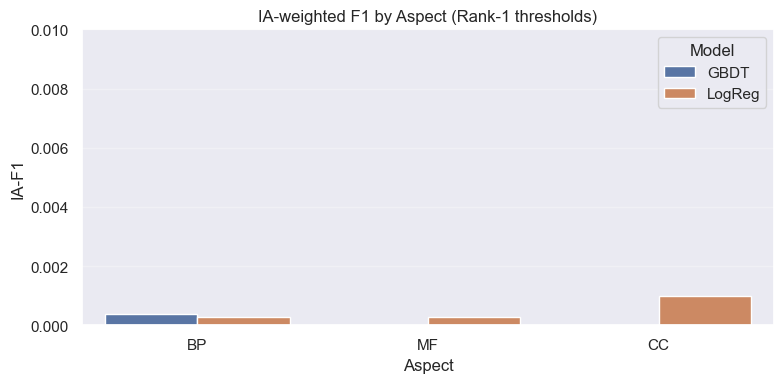

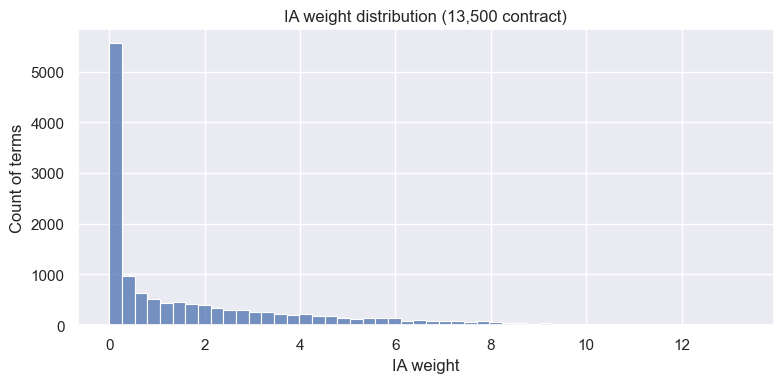

In [10]:
# Bar plot: per-aspect IA-F1 by model
plot_df = results_df.melt(id_vars='Aspect', value_vars=['GBDT_IA_F1', 'LogReg_IA_F1'], var_name='Model', value_name='IA_F1')
plot_df['Model'] = plot_df['Model'].str.replace('_IA_F1', '', regex=False)

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=plot_df, x='Aspect', y='IA_F1', hue='Model')
ax.set_title('IA-weighted F1 by Aspect (Rank-1 thresholds)')
ax.set_ylabel('IA-F1')
ax.set_xlabel('Aspect')
ax.set_ylim(0, max(0.01, float(plot_df['IA_F1'].max()) * 1.2))
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram: IA weight distribution for the 13,500-term contract
plt.figure(figsize=(8, 4))
sns.histplot(ia_weights, bins=50)
plt.title('IA weight distribution (13,500 contract)')
plt.xlabel('IA weight')
plt.ylabel('Count of terms')
plt.tight_layout()
plt.show()

In [11]:
# Optional: save the IA results to CSV (small, deterministic artefact)
out_path = LEVEL1_PREDS / 'oof_eval_ia_f1_rank1_thresholds.csv'
out_df = results_df.copy()
out_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\cafa6_data\features\level1_preds\oof_eval_ia_f1_rank1_thresholds.csv


## 7. Summary (IA Metric)

In [12]:
# Compact summary view
print("="*60)
print("IA-WEIGHTED SUMMARY (Rank-1 thresholds)")
print("="*60)

overall = pd.DataFrame([
    {'Model': 'GBDT', 'IA_F1': gbdt_f1, 'Precision': gbdt_p, 'Recall': gbdt_r},
    {'Model': 'LogReg', 'IA_F1': lr_f1, 'Precision': lr_p, 'Recall': lr_r},
]).set_index('Model')

display(overall.style.format('{:.4f}'))
print("\nPer-aspect IA-F1:")
display(results_df.set_index('Aspect').style.format('{:.4f}'))

IA-WEIGHTED SUMMARY (Rank-1 thresholds)


,IA_F1,Precision,Recall
Model,,,
GBDT,0.0002,0.0041,0.0001
LogReg,0.0003,0.0002,0.0988



Per-aspect IA-F1:


,GBDT_IA_F1,GBDT_P,GBDT_R,LogReg_IA_F1,LogReg_P,LogReg_R
Aspect,,,,,,
BP,0.0004,0.0048,0.0002,0.0003,0.0001,0.1747
MF,0.0000,0.0007,0.0000,0.0003,0.0001,0.0228
CC,0.0000,0.0000,0.0000,0.0010,0.0005,0.0623


## 8. (Optional) Additional Plots

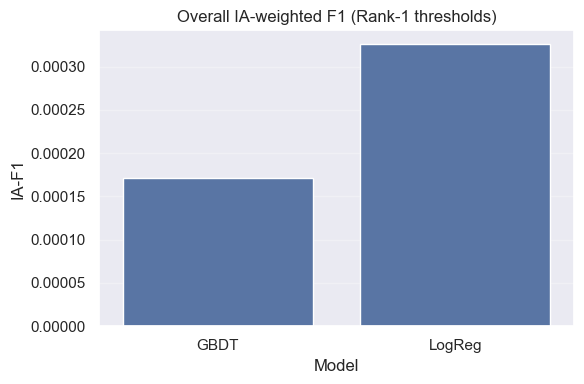

In [13]:
# Overall IA-F1 bar plot (GBDT vs LogReg)
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=summary_df, x='Model', y='IA_F1')
ax.set_title('Overall IA-weighted F1 (Rank-1 thresholds)')
ax.set_ylabel('IA-F1')
ax.set_xlabel('Model')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Results

In [14]:
# Save a single tidy table with overall + per-aspect IA-F1
out_path2 = LEVEL1_PREDS / 'oof_eval_ia_f1_rank1_thresholds_overall_and_aspects.csv'
tidy = pd.concat([
    summary_df.assign(Aspect='Overall')[['Aspect', 'Model', 'IA_F1', 'Precision', 'Recall']],
    results_df.melt(id_vars='Aspect', value_vars=['GBDT_IA_F1', 'LogReg_IA_F1'], var_name='Model', value_name='IA_F1')
        .assign(Model=lambda d: d['Model'].str.replace('_IA_F1', '', regex=False))
        .merge(
            results_df[['Aspect','GBDT_P','GBDT_R','LogReg_P','LogReg_R']]
                .assign(GBDT_Model='GBDT', LogReg_Model='LogReg')
            , how='left', on='Aspect'
        )
], ignore_index=True)

# Keep it simple: write overall table + per-aspect IA_F1 only
tidy = pd.concat([
    summary_df.assign(Aspect='Overall')[['Aspect','Model','IA_F1','Precision','Recall']],
    results_df[['Aspect','GBDT_IA_F1','LogReg_IA_F1']].rename(columns={'GBDT_IA_F1':'GBDT','LogReg_IA_F1':'LogReg'})
        .melt(id_vars='Aspect', var_name='Model', value_name='IA_F1')
], ignore_index=True)

tidy.to_csv(out_path2, index=False)
print(f"Saved: {out_path2}")

Saved: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\cafa6_data\features\level1_preds\oof_eval_ia_f1_rank1_thresholds_overall_and_aspects.csv


## 10. Interpretation

**If IA-F1 is still low, the usual culprits are alignment bugs, not model quality:**
1. **EntryID ↔ row order mismatch** between `train_seq.feather` and the OOF arrays.
2. **Term order mismatch** (contract order must be `top_terms_BP + top_terms_MF + top_terms_CC`).
3. **IA weights missing/misread** (this notebook uses `cafa6_data/IA.tsv`; missing weights default to 0.0).
4. **Thresholds too strict** (Rank-1 heuristics are a baseline; per-term tuning can move scores).

**Sanity check you can trust:**
- If `Y_true.nnz` is tiny or `debug['true_nonzero_terms']` is near 0, your ground truth mapping is broken.
- If `debug['pred_nonzero_terms']` is near 0, your thresholds are too high or predictions are near-zero.